*Ce billet a été écrit à l'aide d'un notebook Jupyter. Son contenu est sous licence BSD. Une vue statique de ce notebook peut être consultée et téléchargée ici : [20170508_ElectionsTour1.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170508_ElectionsTour2.ipynb).*

Dans ce billet, nous allons continuer l'exercice du [billet précédent](http://flothesof.github.io/cartes-premier-tour-presidentielle-2017.html) et dessiner quelques cartes en utilisant les données du deuxième tour de l'élection présidentielle 2017. 

En plus de cartes géographiques, nous allons faire des cartes simplifiées qui permettent de mieux appréhender les données de l'élection, inspiré par [cet article de Libération](http://www.liberation.fr/elections-presidentielle-legislatives-2017/2017/04/25/pourquoi-la-simple-carte-n-est-pas-toujours-la-meilleure-forme-pour-raconter-une-election_1565064).

# Obtention des données depuis le site du ministère de l'intérieur et analyse sommaire 

Comme dans mon billet précédent, nous allons directement utiliser les données officielles, disponibles ici: <http://elections.interieur.gouv.fr/presidentielle-2017/>. Nous utilisons la stratégie précédente, qui consiste à utiliser les liens affichés sur la carte pour obtenir les résultats par département. Dans un premier temps, nous récupérons les liens vers les pages individuelles des départements :

In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
soup = BeautifulSoup(requests.get('http://elections.interieur.gouv.fr/presidentielle-2017/').text, 'html.parser')

In [3]:
map_tag = soup.find('map')

In [4]:
area_tags = map_tag.find_all('area')

In [5]:
links = [tag.attrs['href'] for tag in area_tags]

In [6]:
unique_links = set(links)

Dans un deuxième temps, j'ai modifié la fonction du billet précédent pour également permettre d'obtenir les données concernant les abstentions, les votes nuls et les votes blancs.

In [7]:
def extract_candidate_votes(url):
    "Extracts votes for all candidates from a given url."
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    # département name
    dept = soup.find(class_='span12 pub-fil-ariane').find_all('a')[-1].text
    # candidate votes
    table = soup.find('tbody')
    results = {}
    for row in table.find_all('tr'):
        results[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
    # other data: non-voters, nil, invalid
    second_table = soup.find_all('tbody')[1]
    for row in second_table.find_all('tr'):
        if row.td.text in ['Blancs', 'Nuls', 'Abstentions']:
            results[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
    return dept, results

Testons cette fonction sur le département des Vosges.

In [8]:
url = "http://elections.interieur.gouv.fr/presidentielle-2017/" + list(unique_links)[0]

In [9]:
extract_candidate_votes(url)

('Haute-Garonne (31)',
 {'Abstentions': 220547,
  'Blancs': 60546,
  'M. Emmanuel MACRON': 436941,
  'Mme Marine LE PEN': 166668,
  'Nuls': 22130})

Cela fonctionne : appliquons ceci à chacun des départements pour construire une grande table de données.

In [10]:
depts = []
results = []
for link in unique_links:
    dept, result = extract_candidate_votes("http://elections.interieur.gouv.fr/presidentielle-2017/" + link) 
    depts.append(dept)
    results.append(result)

In [11]:
import pandas as pd

In [12]:
df_votes = pd.DataFrame(results, index=depts)

In [13]:
df_votes.head(10)

,Abstentions,Blancs,M. Emmanuel MACRON,Mme Marine LE PEN,Nuls
Haute-Garonne (31),220547,60546,436941,166668,22130
Loiret (45),103643,30731,195004,113735,9508
Aveyron (12),43933,16665,109340,40838,7403
Haute-Marne (52),32083,9057,45192,44331,3456
Territoire de Belfort (90),23202,6743,36340,26121,2873
Haute-Savoie (74),127886,37148,249127,113718,10282
Val-d'Oise (95),204202,42933,342000,129536,11664
Orne (61),45577,14762,88484,55070,4798
Bouches-du-Rhône (13),364023,81855,519335,378455,26391
Wallis et Futuna (986),2369,76,4715,1243,61


Nous pouvons par exemple sommer les données pour tous les départements et afficher le résultat.

In [14]:
df_votes.sum(axis=0).to_frame(name='Somme des votes')

,Somme des votes
Abstentions,12101416
Blancs,3019724
M. Emmanuel MACRON,20753798
Mme Marine LE PEN,10644118
Nuls,1049532


On peut représenter ceci sous forme de graphique :

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

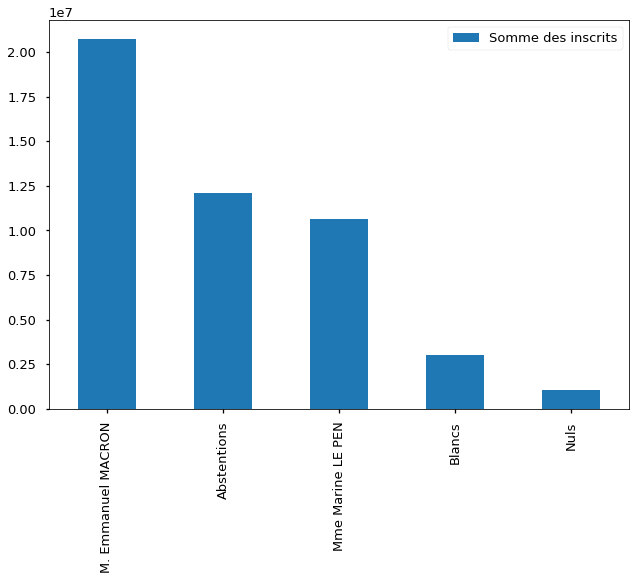

In [16]:
df_votes.sum(axis=0).to_frame(name='Somme des inscrits').sort_values(by='Somme des inscrits', ascending=False).plot.bar()

On peut refaire ce même graphique en proportion du total des voix qui pouvaient s'exprimer.

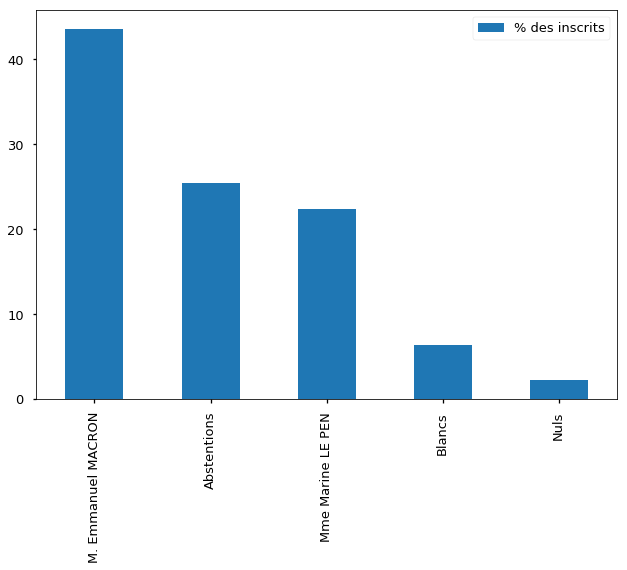

In [17]:
(df_votes.sum(axis=0) / df_votes.sum(axis=0).sum() * 100).to_frame(name='% des inscrits').sort_values(by='% des inscrits', ascending=False).plot.bar()

On peut noter que plus de personnes se sont abstenues que n'ont voté pour Marine Le Pen.

Comme dans mon billet précédent, on peut dessiner un diagramme vertical avec la répartition de toutes ces quantités en fonction des départements :

In [18]:
vote_sum = df_votes.sum(axis=1).sort_values(ascending=True)
df_votes['total'] = vote_sum
df_votes = df_votes.sort_values(by='total', ascending=True)
df_votes = df_votes.drop('total', 1)

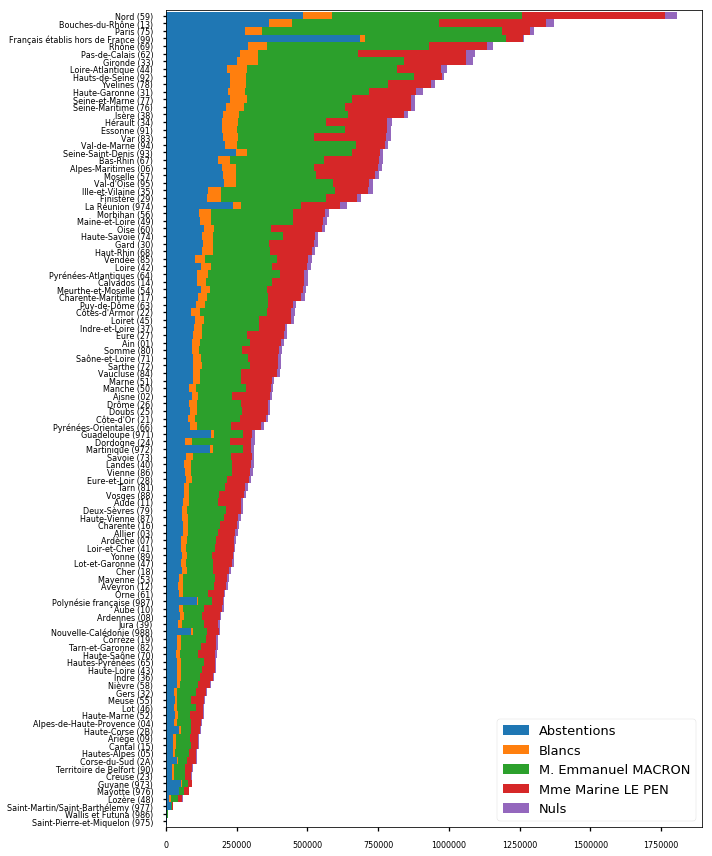

In [19]:
fig, ax = plt.subplots(figsize=(10, 12))
df_votes.plot.barh(ax=ax, stacked=True, fontsize=8, width=1)
plt.tight_layout()

Le graphique précédent est intéressant. En particulier, il permet d'identifier visuellement le fait que l'abstentionnisme semble beaucoup plus prononcé chez les français de l'étranger et dans les DOM-TOM.

Passons maintenant à la partie cartographie de ce billet. Nous allons dessiner des cartes à l'aide des données précédentes.

# Cartes 

Au lieu de faire des cartes géographiques utilisant les contours géographiques, nous allons contrairement au billet précédent représenter le vote à l'aide de cercles dont la taille représente le nombre de votants. Ces cercles sont placé sur la centroïde géographique département en question.

In [20]:
import shapefile

In [21]:
r = shapefile.Reader(r"files/departement_shapes/DEPARTEMENT.shp")
shapes = r.shapes()
records = r.records()
fields = r.fields

In [22]:
import numpy as np
from matplotlib.collections import LineCollection

def draw_departements_and_centroids(ax, records, shapes, radii=None):
    "Draws a map of the départements."
    if radii is None:
        radii = [10000 for _ in range(len(records))]
    for record, shape, radius in zip(records, shapes, radii):
        lons, lats = zip(*shape.points)
        data = np.array([lons, lats]).T

        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])

        lines = LineCollection(segs,antialiaseds=(1,))
        lines.set_edgecolors('k')
        lines.set_linewidth(0.3)
        ax.add_collection(lines)
        
        centroid = data.mean(axis=0)
        ax.add_artist(plt.Circle(centroid, radius=radius, alpha=0.7))

(71326.0, 1328512.0, 6008968.0, 7159443.0)

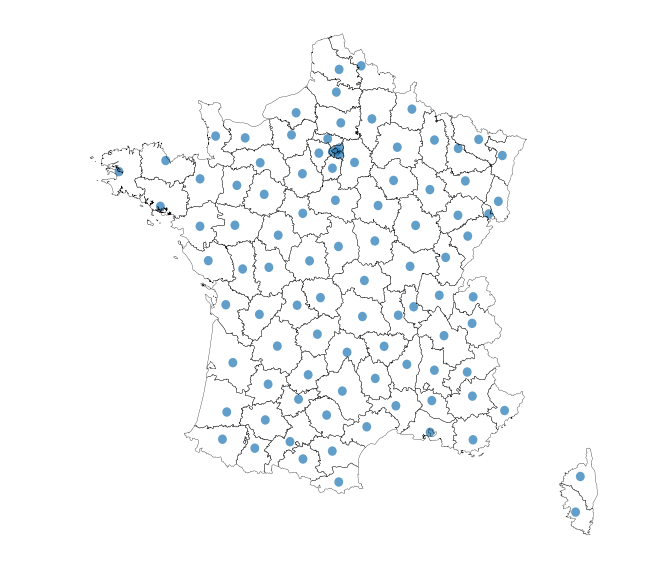

In [23]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

draw_departements_and_centroids(ax, records, shapes)

df = pd.DataFrame(records, columns=[f[0] for f in fields[1:]])
xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
plt.xlim(xmin - 100000, xmax + 100000)
plt.ylim(ymin - 100000, ymax + 100000)
plt.axis('off')

On peut maintenant dessiner des cartes avec les données issues du site du ministère de l'intérieur.

In [24]:
def get_radii(label_idx, iterable=df.CODE_DEPT):
    """Returns sorted radii by correct label index."""
    s = df_votes[df_votes.columns[label_idx]]
    radii = []
    for code_dpt in iterable:
        values = s[s.index.str.contains("({})".format(code_dpt), regex=False)].values
        radii.append(values)
    return np.array(radii)

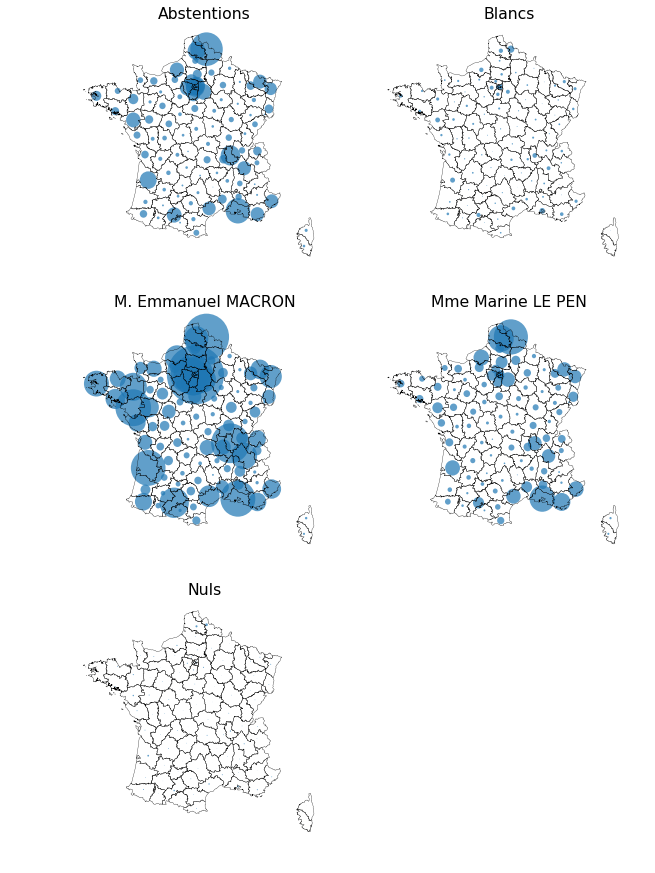

In [25]:
fig = plt.figure(figsize=(10, 15))
for label_idx in np.arange(df_votes.columns.size):
    ax = plt.subplot(3, 2, label_idx+1)

    radii = get_radii(label_idx) / 6
    draw_departements_and_centroids(ax, records, shapes, radii)

    xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
    ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
    ax.set_xlim(xmin - 100000, xmax + 100000)
    ax.set_ylim(ymin - 100000, ymax + 100000)
    ax.axis('off')
    ax.set_title(df_votes.columns[label_idx])

Le problème de la représentation précédente, c'est que les cercles se recouvrent. On va donc utiliser un autre environnement pour représenter les données : une libraire de graphes, `networkx`.

On va construire un graphe qui relie chaque département à son plus proche centroïde voisin. Puis on va trouver une disposition qui permet de représenter facilement chaque département.

In [26]:
import networkx as nx

In [27]:
code_to_idx = dict(zip(df.CODE_DEPT, np.arange(df.shape[0])))

In [28]:
idx_to_code = dict(zip(np.arange(df.shape[0]), df.CODE_DEPT))

In [29]:
centroids = np.array([np.array(shape.points).mean(axis=0) for shape in shapes])

In [30]:
from scipy.spatial import KDTree

In [31]:
kdtree = KDTree(centroids)

In [32]:
kdtree.data.shape

(96, 2)

Avec l'algorithme de plus proche voisin, on peut facilement déterminer les plus proches voisins d'un noeud donné à l'aide de la fonction `query`.

In [33]:
kdtree.query(kdtree.data[2], 3)

(array([     0.        ,  48030.21679557,  90082.12623391]),
 array([ 2, 44, 89]))

On va également construire un dictionnaire du nombre de votes par département :

In [34]:
vote_sum[vote_sum.index.str.contains("({})".format(12), regex=False)].values[0]

218179

In [35]:
pop_dict = dict(zip(df.CODE_DEPT, [vote_sum[vote_sum.index.str.contains("({})".format(idx), regex=False)].values[0] for idx in df.CODE_DEPT]))

Construisons maintenant le graphe :

In [36]:
G=nx.Graph()
for dept_id, centroid in zip(df.CODE_DEPT, range(centroids.shape[0])):
    G.add_node(dept_id)
    node_id = code_to_idx[dept_id]
    dists, neighbors = kdtree.query(kdtree.data[node_id], k=7)
    for neighbor in neighbors[1:]:
        neighbor_id = idx_to_code[neighbor]
        weight = -(pop_dict[neighbor_id])
        G.add_edge(dept_id, neighbor_id, weight=weight)

In [37]:
weight

-428840

On va initialement positionner les départements à leurs coordonnées centroïdes :

In [38]:
initial_pos = dict(zip([idx_to_code[idx] for idx in range(centroids.shape[0])], centroids))

/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

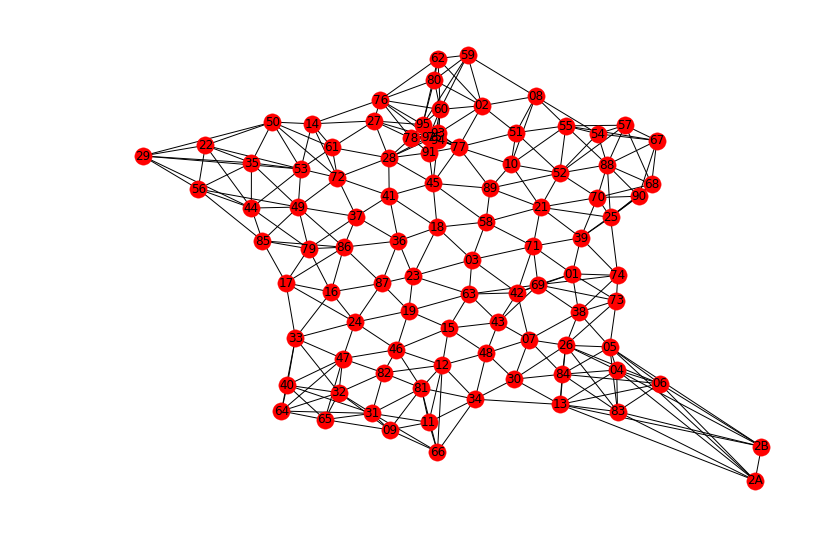

In [39]:
nx.draw(G, pos=initial_pos, with_labels=True)

Et puis on va ensuite donner un nouveau placement à l'aide d'un layout de type ressort.

In [40]:
pos=nx.spring_layout(G, pos=initial_pos, fixed=['75'], iterations=2, k=1e9, weight='weight')

/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

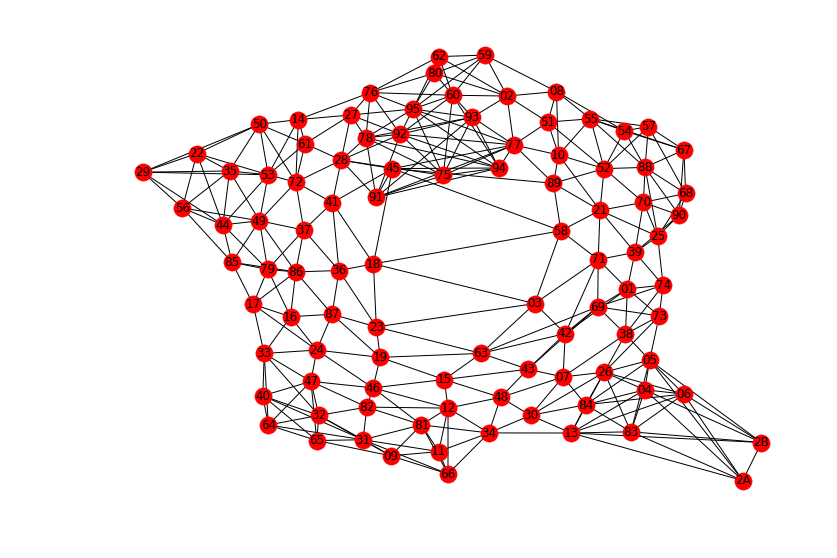

In [41]:
nx.draw(G, pos, with_labels=True)

Avec ce nouveau placement des départements, on peut maintenant essayer de dessiner des cercles de tailles différentes. Dans un premier temps, on dessine avec la taille de population.

/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

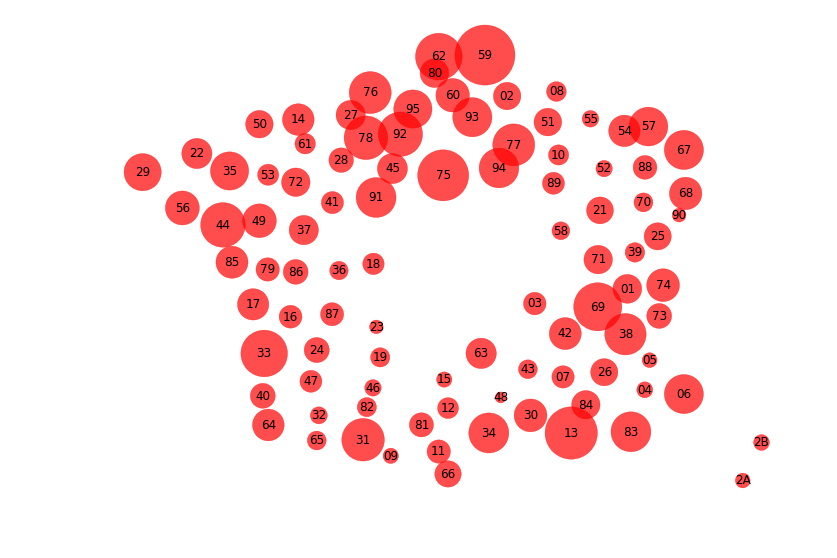

In [49]:
nx.draw(G, pos, with_labels=True, node_size=[pop_dict[i]/500 for i in G.nodes()], alpha=0.7, width=0., scale=4)

On peut maintenant refaire les différentes cartes précédentes.

In [43]:
df_votes['abstention, nuls, blancs'] = df_votes.Abstentions + df_votes.Nuls + df_votes.Blancs

In [44]:
df_votes.columns

Index(['Abstentions', 'Blancs', 'M. Emmanuel MACRON', 'Mme Marine LE PEN',
       'Nuls', 'abstention, nuls, blancs'],
      dtype='object')

In [45]:
def get_radii_by_col(col_label, iterable=df.CODE_DEPT):
    """Returns sorted radii by correct label index."""
    s = df_votes[col_label]
    radii = []
    for code_dpt in iterable:
        values = s[s.index.str.contains("({})".format(code_dpt), regex=False)].values
        radii.append(values)
    return np.array(radii)

/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/kappamaki/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/kappamaki/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

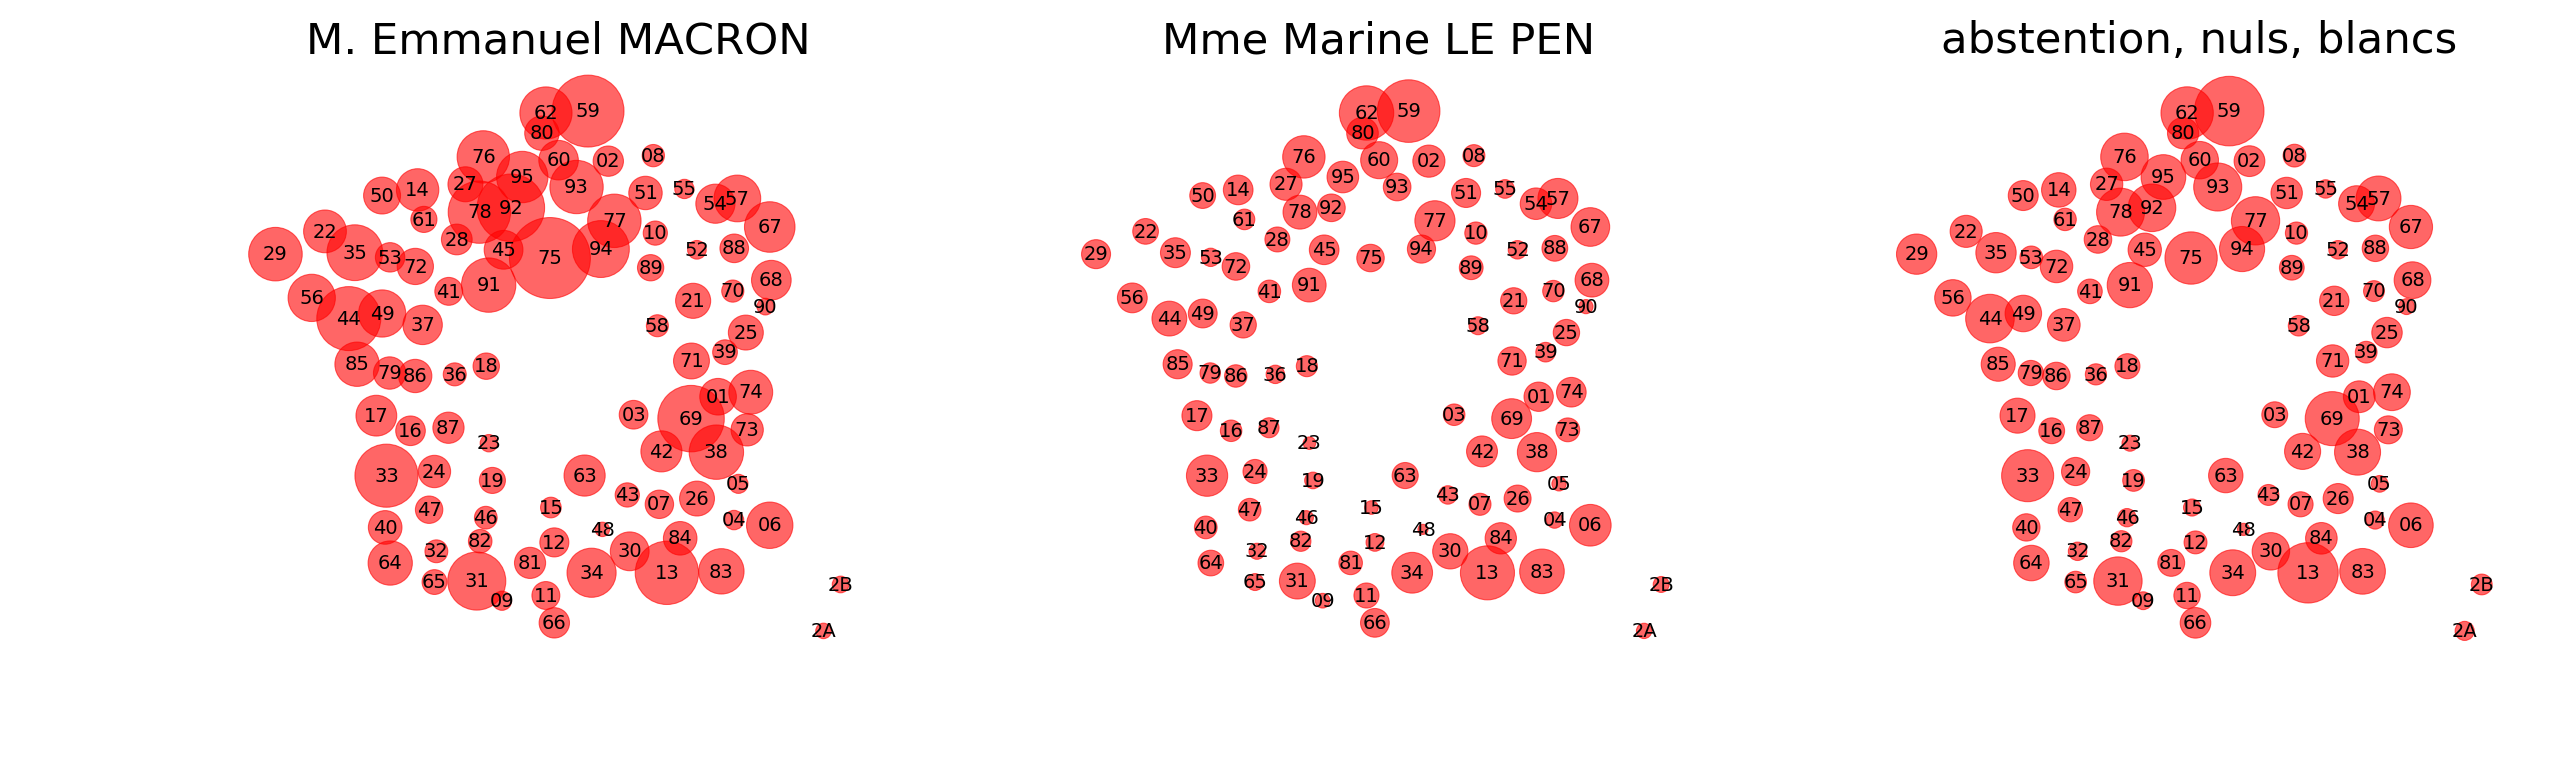

In [51]:
fig = plt.figure(figsize=(15, 4), dpi=200)
for ind, col_label in enumerate(['M. Emmanuel MACRON', 'Mme Marine LE PEN', 'abstention, nuls, blancs']):
    ax = plt.subplot(1, 3, ind+1)
    radii = get_radii_by_col(col_label, iterable=G.nodes()) / 1000
    nx.draw(G, pos, with_labels=True, node_size=radii, ax=ax, alpha=0.6, width=0., font_size=7, scale=10.)
    ax.set_title(col_label)
    plt.axis('equal')

Ces trois cartes permettent de comparer les votes en fonction des deux candidats ainsi que l'abstention. On se rend ici compte que l'abstention est, dans de nombreux départements, plus forte que le vote pour Marine Le Pen par exemple, ce qui témoigne de l'importance de cet effet.

# Conclusions 

Dans ce billet, nous avons utilisé les données du ministère de l'intérieur pour analyser les résultats du second tour de l'élection présidentielle 2017. Ceci nous a permis de voir que les manières de voter sont différente selon les départements français. Nous avons également dessiné quelques cartes en essayant d'avoir une approche à la fois basée sur la géographie et sur une manière pertinente de représentation des données, qui sont assez complexes à appréhender.